# Freesound General Purpose Audio Tagging Submission Notebook
### Graham Bachman

This notebook is just the code used to generate predictions on the test set of spectrogram images for the kaggle competiton. 

## Load Data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import keras
from keras_preprocessing.image import ImageDataGenerator

## Create Dataframes

In [2]:
train = pd.read_csv('../input/freesound-audio-tagging/train.csv')
train['image_file'] = train.fname.apply(lambda x : x[:-4] + '.jpg')
print(train.shape)
train.head()

(9473, 4)


,fname,label,manually_verified,image_file
0,00044347.wav,Hi-hat,0,00044347.jpg
1,001ca53d.wav,Saxophone,1,001ca53d.jpg
2,002d256b.wav,Trumpet,0,002d256b.jpg
3,0033e230.wav,Glockenspiel,1,0033e230.jpg
4,00353774.wav,Cello,1,00353774.jpg


In [3]:
test = pd.read_csv('../input/freesound-audio-tagging/test_post_competition.csv')
test['image_file'] = test.fname.apply(lambda x : x[:-4] + '.jpg')
print(test.shape)
test.head()

(9400, 6)


,fname,label,usage,freesound_id,license,image_file
0,00063640.wav,None,Ignored,88926,Attribution,00063640.jpg
1,0013a1db.wav,None,Ignored,373335,Creative Commons 0,0013a1db.jpg
2,002bb878.wav,None,Ignored,189611,Attribution,002bb878.jpg
3,002d392d.wav,None,Ignored,35939,Attribution,002d392d.jpg
4,00326aa9.wav,Oboe,Private,355125,Attribution,00326aa9.jpg


In [4]:
test_public = test.query('label != "None"').copy()
print(test_public.shape)
test_public.head()

(1600, 6)


,fname,label,usage,freesound_id,license,image_file
4,00326aa9.wav,Oboe,Private,355125,Attribution,00326aa9.jpg
5,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0,0038a046.jpg
8,007759c4.wav,Saxophone,Private,13406,Creative Commons 0,007759c4.jpg
9,008afd93.wav,Saxophone,Private,358962,Attribution,008afd93.jpg
12,00ae03f6.wav,Chime,Private,78203,Attribution,00ae03f6.jpg


## Data Generator

In [5]:
test_public_path = '../input/freesound-2018-100dpi/labeled_test_images'
test_path = '../input/freesound-2018-100dpi/full_test_images'

print(len(os.listdir(test_public_path)))
print(len(os.listdir(test_path)))

1600
9400


In [6]:
bs = 64
target_size = (50, 75)

public_test_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

public_test_gen = public_test_datagen.flow_from_dataframe(
    dataframe = test_public,
    directory = test_public_path,
    x_col = 'image_file',
    y_col = 'label',
    batch_size = bs,
    seed = 1,
    shuffle = False,
    class_mode = 'categorical',
    target_size = target_size
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = 'image_file',
    y_col = None,
    batch_size = bs,
    seed = 1,
    shuffle = False,
    class_mode = None,
    target_size = target_size
)

Found 1600 validated image filenames belonging to 41 classes.
Found 9400 validated image filenames.


In [7]:
test_batches = len(test_gen)
public_test_batches = len(public_test_gen)

print(test_batches)
print(public_test_batches)

147
25


In [8]:
label_to_index = public_test_gen.class_indices
index_to_label = {v:k for k,v in label_to_index.items()}
print(label_to_index)

{'Acoustic_guitar': 0, 'Applause': 1, 'Bark': 2, 'Bass_drum': 3, 'Burping_or_eructation': 4, 'Bus': 5, 'Cello': 6, 'Chime': 7, 'Clarinet': 8, 'Computer_keyboard': 9, 'Cough': 10, 'Cowbell': 11, 'Double_bass': 12, 'Drawer_open_or_close': 13, 'Electric_piano': 14, 'Fart': 15, 'Finger_snapping': 16, 'Fireworks': 17, 'Flute': 18, 'Glockenspiel': 19, 'Gong': 20, 'Gunshot_or_gunfire': 21, 'Harmonica': 22, 'Hi-hat': 23, 'Keys_jangling': 24, 'Knock': 25, 'Laughter': 26, 'Meow': 27, 'Microwave_oven': 28, 'Oboe': 29, 'Saxophone': 30, 'Scissors': 31, 'Shatter': 32, 'Snare_drum': 33, 'Squeak': 34, 'Tambourine': 35, 'Tearing': 36, 'Telephone': 37, 'Trumpet': 38, 'Violin_or_fiddle': 39, 'Writing': 40}


## Load and summarize our best model

In [9]:
new_model = keras.models.load_model('../input/models/freesound_model_v03_50.h5')
new_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 50, 75, 128)       3584      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 50, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 37, 128)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 25, 37, 128)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 25, 37, 128)       512       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 25, 37, 256)       295168    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 25, 37, 256)      

## Make predictions

In [10]:
%%time 

valid_probs = new_model.predict(public_test_gen, steps=public_test_batches)

print(valid_probs.shape)

(1600, 41)
CPU times: user 1min 44s, sys: 8.14 s, total: 1min 52s
Wall time: 30.2 s


## Mean Average Precision
Mean Average Precision (MAP) is the metric used in this kaggle competition for assessing submissions. 
It accepts three ranked predicted labels for each audio clip. Full credit is awarded if the correct label is listed first, while lesser credit is awarded where the correct label is the second or third highest probability. 
### Define function to obtain top 3 highest class probabilities

In [11]:
def get_top_3(p):
    top_classes = np.argpartition(p, -3)[-3:]                  # Gives top 3 classes in increasing order
    top_classes = top_classes[np.argsort(p[top_classes])]      # Sorts in increasing order
    top_classes = np.flip(top_classes)                         # Flips the order.

    top_probs = p[top_classes]              
    
    return top_probs, top_classes

t3p, t3c = get_top_3(valid_probs[0,:])
print(t3p.round(3))
print(t3c)

[0.921 0.022 0.01 ]
[29  8 30]


### Visualize

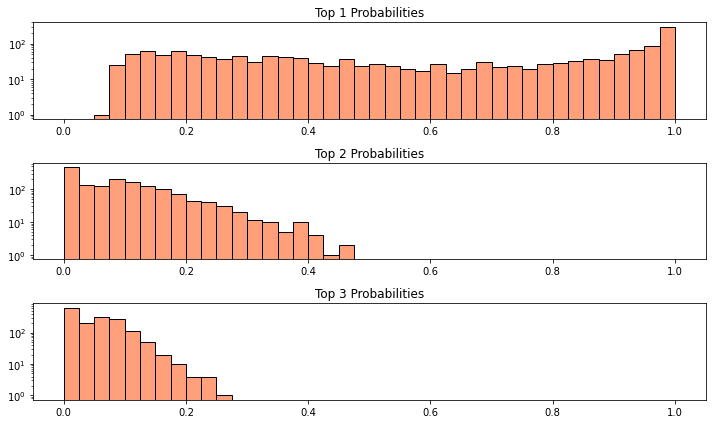

In [12]:
N_train = valid_probs.shape[0]
top_3_probs = np.zeros(shape=(N_train, 3))

for i in range(N_train):    
    top_probs, top_classes = get_top_3(valid_probs[i, :])
    top_3_probs[i,:] = top_probs

plt.figure(figsize=[10,6])
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.hist(top_3_probs[:,i], color='lightsalmon', edgecolor='k', bins = np.arange(0, 1.01, 0.025))
    plt.title(f'Top {i+1} Probabilities')
    plt.yscale('log')
plt.tight_layout()
plt.show()

In [13]:
enc_labels = test_public.label.apply(lambda x : label_to_index[x]).values
print(enc_labels)

[29  3 30 ... 31 11  8]


In [14]:
def MAP3(probs, labels, t):
    N = len(labels)
    top_3_probs = np.zeros(shape=(N, 3))
    sum_ap3 = 0

    for i in range(N):
        top_probs, top_classes = get_top_3(probs[i, :])

        # Keep Probs Over Threshold
        sel = top_probs > t
        sel[0] = True                               # Always keep first pred

        top_classes = top_classes[sel]

        K = len(top_classes)   # Number of classes to submit
        if K == 3:
            scores = np.array([11/18, 5/18, 2/18])
        elif K == 2:
            scores = np.array([3/4, 1/4])
        else:
            scores = np.array([1])

        sel = (top_classes == labels[i])

        #print(f'{str(top_classes):<20}{labels[i]:<6}{sel}')

        ap3 = np.sum(scores * sel)

        sum_ap3 += ap3

    map3 = sum_ap3 / len(labels)

    return map3

MAP3(valid_probs, enc_labels, 0.5)

0.705

## Tune Threshold

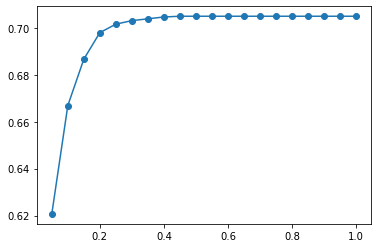

In [15]:
MAP3_scores = []

t_array = np.arange(0.05, 1.01, 0.05) 

for t in t_array:
    MAP3_scores.append(MAP3(valid_probs, enc_labels, t))
    
plt.plot(t_array, MAP3_scores)
plt.scatter(t_array, MAP3_scores)
plt.show()

## Make predictions on the test set and create submission file

In [16]:
%%time 

test_probs = new_model.predict(test_gen, steps=test_batches)

print(test_probs.shape)

(9400, 41)
CPU times: user 10min 14s, sys: 46.6 s, total: 11min
Wall time: 2min 52s


In [17]:
submission = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
submission.head()

,fname,label
0,00063640.wav,Laughter Hi-Hat Flute
1,0013a1db.wav,Laughter Hi-Hat Flute
2,002bb878.wav,Laughter Hi-Hat Flute
3,002d392d.wav,Laughter Hi-Hat Flute
4,00326aa9.wav,Laughter Hi-Hat Flute


In [18]:
np.sum(submission.fname == test.fname)
print(test_probs[:5, :5])

[[5.1800259e-03 3.3351835e-03 6.3604005e-03 1.4245233e-02 3.4070753e-03]
 [4.9991142e-03 1.9124509e-03 1.2886375e-02 1.1377556e-03 2.4223579e-03]
 [3.2885843e-03 7.2340164e-03 8.9811953e-03 2.0509733e-01 9.9427847e-04]
 [3.4444895e-02 3.3509720e-04 1.8027582e-03 4.7882959e-01 4.3099633e-04]
 [1.1266179e-03 4.3234593e-04 1.1231715e-03 5.8523746e-04 5.4613221e-04]]


In [19]:
t = 0.2

for i in range(len(submission)):
#for i in range(10):
    
    # Get top 3 classes
    top_probs, top_classes = get_top_3(test_probs[i, :])
    
    # Select only those above threshold
    sel = top_probs > t
    sel[0] = True
    sel_classes = top_classes[sel]
    
    pred_labels = [index_to_label[i] for i in sel_classes]
    pred_string = ' '.join(pred_labels)
    submission.loc[i, 'label'] = pred_string
    
submission.head(20)

,fname,label
0,00063640.wav,Shatter
1,0013a1db.wav,Flute
2,002bb878.wav,Fireworks Bass_drum
3,002d392d.wav,Bass_drum Double_bass
4,00326aa9.wav,Oboe
5,0038a046.wav,Bass_drum
6,003995fa.wav,Squeak
7,005ae625.wav,Acoustic_guitar
8,007759c4.wav,Flute
9,008afd93.wav,Saxophone


In [20]:
submission.to_csv('submission_02.csv', index=False)